# 캐글 신용카드 사기 검출

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

- 데이터 전처리 및 훈련/테스트 데이터셋 분리

In [5]:
from sklearn.model_selection import train_test_split
X = df.values[:,1:-1]           # X = df.iloc[:,1:-1].values
y = df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

In [8]:
label, count = np.unique(y_train, return_counts=True)
label, count

(array([0, 1], dtype=int64), array([199020,    344], dtype=int64))

In [11]:
# 학습 데이터 레이블 값 비율
_, count = np.unique(y_train, return_counts=True)
print(f'학습 데이터 레이블 값 비율: {count[1]/y_train.shape[0] * 100:.4f} %')

# 테스트 데이터 레이블 값 비율
_, count = np.unique(y_test, return_counts=True)
print(f'테스트 데이터 레이블 값 비율: {count[1]/y_test.shape[0] * 100:.4f} %')

학습 데이터 레이블 값 비율: 0.1725 %
테스트 데이터 레이블 값 비율: 0.1732 %


In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
def get_clf_eval(y, pred):
    print(confusion_matrix(y, pred))
    print(f'정확도: {accuracy_score(y, pred):.4f}, 정밀도: {precision_score(y, pred):.4f}, 재현율: {recall_score(y, pred):.4f}, F1: {f1_score(y, pred):.4f}')

- Logistic Regression 적용

In [13]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter=1000)
%time lrc.fit(X_train, y_train)
lr_pred = lrc.predict(X_test)

Wall time: 37.2 s


In [14]:
get_clf_eval(y_test, lr_pred)

[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149, F1: 0.7194


- LightGBM

In [15]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [16]:
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, objective='binary', boost_from_average=False)
%time lgbm.fit(X_train, y_train)
lg_pred = lgbm.predict(X_test)

Wall time: 17.1 s


In [17]:
get_clf_eval(y_test, lg_pred)

[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453


- 표준정규분포로 정규화한 후 시행

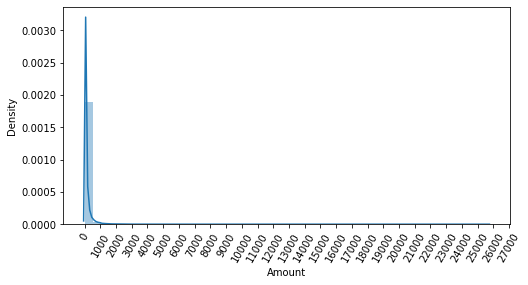

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(df['Amount']);

In [19]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(df.values[:,1:-1])
X_train2, X_test2, y_train, y_test = train_test_split(
    X_std, df['Class'].values, stratify=df['Class'].values,
    test_size=0.3, random_state=2021
)

In [20]:
# 로지스틱 회귀
lrc2 = LogisticRegression()
%time lrc2.fit(X_train2, y_train)
lr_pred2 = lrc2.predict(X_test2)
get_clf_eval(y_test, lr_pred2)

Wall time: 2.62 s
[[85278    17]
 [   56    92]]
정확도: 0.9991, 정밀도: 0.8440, 재현율: 0.6216, F1: 0.7160


In [21]:
# Light GBM
lgbm2 = LGBMClassifier(n_estimators=1000, num_leaves=64, objective='binary', boost_from_average=False)
lgbm2.fit(X_train2, y_train)
lg_pred2 = lgbm2.predict(X_test2)
get_clf_eval(y_test, lg_pred2)

[[85289     6]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9496, 재현율: 0.7635, F1: 0.8464


- 'V14' 이상치(Outlier) 제거

In [22]:
def find_outlier(df, col, y):
    s = df[df[y] == 1][col]
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    fraud_index = s[(s < lower) | (s > upper)].index
    return fraud_index

In [23]:
indices = find_outlier(df, 'V14', 'Class')
indices

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [24]:
df.shape

(284807, 31)

In [25]:
df.drop(indices, inplace=True)
df.shape

(284803, 31)

- LogisticRegression, LightGBM 새로 적용

In [26]:
X_std = StandardScaler().fit_transform(df.values[:,1:-1])
X_train3, X_test3, y_train, y_test = train_test_split(
    X_std, df['Class'].values, stratify=df['Class'].values,
    test_size=0.3, random_state=2021
)

In [27]:
# 로지스틱 회귀
lrc3 = LogisticRegression()
lrc3.fit(X_train3, y_train)
lr_pred3 = lrc3.predict(X_test3)
get_clf_eval(y_test, lr_pred3)

[[85277    18]
 [   55    91]]
정확도: 0.9991, 정밀도: 0.8349, 재현율: 0.6233, F1: 0.7137


In [28]:
# Light GBM
lgbm3 = LGBMClassifier(n_estimators=1000, num_leaves=64, objective='binary', boost_from_average=False)
lgbm3.fit(X_train3, y_train)
lg_pred3 = lgbm3.predict(X_test3)
get_clf_eval(y_test, lg_pred3)

[[85290     5]
 [   36   110]]
정확도: 0.9995, 정밀도: 0.9565, 재현율: 0.7534, F1: 0.8429
